In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tqdm
from tqdm import tqdm
import torch
from torch import nn
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
from torchvision.datasets import CIFAR10
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
#train on cifar10 data
# Create Data Generators
input_size = 224
train_trans = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

data_set = CIFAR10(".", train=True, download=True, transform=train_trans)

use_gpu = torch.cuda.is_available()
device = torch.device("cuda" if use_gpu else "cpu")
train_loader = torch.utils.data.DataLoader(data_set, batch_size = 32, shuffle=True, num_workers=4)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CustomBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(CustomBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Root(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1):
        super(Root, self).__init__()
        self.conv = nn.Conv2d(
            in_channels, out_channels, kernel_size,
            stride=1, padding=(kernel_size - 1) // 2, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, xs):
        x = torch.cat(xs, 1)
        out = F.relu(self.bn(self.conv(x)))
        return out


class Tree(nn.Module):
    def __init__(self, block, in_channels, out_channels, level=1, stride=1):
        super(Tree, self).__init__()
        self.root = Root(2*out_channels, out_channels)
        if level == 1:
            self.left_tree = block(in_channels, out_channels, stride=stride)
            self.right_tree = block(out_channels, out_channels, stride=1)
        else:
            self.left_tree = Tree(block, in_channels,
                                  out_channels, level=level-1, stride=stride)
            self.right_tree = Tree(block, out_channels,
                                   out_channels, level=level-1, stride=1)

    def forward(self, x):
        out1 = self.left_tree(x)
        out2 = self.right_tree(out1)
        out = self.root([out1, out2])
        return out


class CustomNet(nn.Module):
    def __init__(self, block=CustomBlock, num_classes=10):
        super(CustomNet, self).__init__()
        self.base = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True)
        )

        self.layer1 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(True)
        )

        self.layer3 = Tree(block,  32,  64, level=1, stride=1)
        self.layer4 = Tree(block,  64, 128, level=2, stride=2)
        self.layer5 = Tree(block, 128, 256, level=2, stride=2)
        self.layer6 = Tree(block, 256, 512, level=1, stride=2)
        self.linear = nn.Linear(512, num_classes)

    def forward(self, x):
        out = self.base(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def test():
    net = CustomNet()
    print(net)
    x = torch.randn(1, 3, 32, 32)
    y = net(x)
    print(y.size())

test()

CustomNet(
  (base): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer3): Tree(
    (root): Root(
      (conv): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (left_tree): CustomBlock(
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), strid

In [5]:
import sys
import time

TOTAL_BAR_LENGTH = 65.
last_time = time.time()
begin_time = last_time
best_acc = 0

start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = CIFAR10(
    root='.', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = CIFAR10(
    root='.', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

# Model
print('Building model')
net = CustomNet()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print('Loss: %.3f | Acc: %.3f%% (%d/%d)' % (train_loss, 100.*correct/total, correct, total))


def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

        print('Loss: %.3f | Acc: %.3f%% (%d/%d)' % (test_loss, 100.*correct/total, correct, total))
            # progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            #              % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc


for epoch in range(start_epoch, start_epoch+20):
    train(epoch)
    test(epoch)
    scheduler.step()

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified
==> Building model..

Epoch: 0
Loss: 625.939 | Acc: 40.838% (20419/50000)
Loss: 132.577 | Acc: 51.960% (5196/10000)
Saving..

Epoch: 1
Loss: 425.654 | Acc: 60.908% (30454/50000)
Loss: 116.174 | Acc: 60.720% (6072/10000)
Saving..

Epoch: 2
Loss: 311.142 | Acc: 72.030% (36015/50000)
Loss: 80.968 | Acc: 72.360% (7236/10000)
Saving..

Epoch: 3
Loss: 253.676 | Acc: 77.404% (38702/50000)
Loss: 85.817 | Acc: 72.000% (7200/10000)

Epoch: 4
Loss: 215.655 | Acc: 80.796% (40398/50000)
Loss: 56.404 | Acc: 80.880% (8088/10000)
Saving..

Epoch: 5
Loss: 190.408 | Acc: 83.188% (41594/50000)
Loss: 58.500 | Acc: 80.280% (8028/10000)

Epoch: 6
Loss: 170.714 | Acc: 84.730% (42365/50000)
Loss: 57.436 | Acc: 81.130% (8113/10000)
Saving..

Epoch: 7
Loss: 157.666 | Acc: 86.018% (43009/50000)
Loss: 52.420 | Acc: 82.670% (8267/10000)
Saving..

Epoch: 8
Loss: 144.026 | Acc: 87.326% (43663/50000)
Loss: 42.457 | Acc: 8

In [26]:
testset = CIFAR10(
    root='.', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=500, shuffle=False, num_workers=2)

net.eval()
inputs, targets = next(iter(testloader))
#register a forward hook on model.linear
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
inputs, targets = inputs.to(device), targets.to(device)
# print(inputs.shape)
# print(targets.shape)

net.layer6.register_forward_hook(get_activation('layer6'))
test_linear_output = net(inputs)
test_linear_output = test_linear_output.detach().cpu().numpy()    #(500, 10)

#convert test_linear_output into test_labels (just take argmax index in each row of test_linear_output)
test_labels=[]
for i in range(test_linear_output.shape[0]):
  max_idx = test_linear_output[i].argmax()
  test_labels.append(max_idx)
test_labels = np.array(test_labels)
print(test_labels.shape)

#get test_embeddings
test_embeddings = activation['layer6']
test_embeddings = F.avg_pool2d(test_embeddings, 4)
test_embeddings = test_embeddings.view(test_embeddings.size(0), -1)
test_embeddings = test_embeddings.cpu().numpy()
print(test_embeddings.shape)


Files already downloaded and verified
(500,)
(500, 512)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(500, 2)


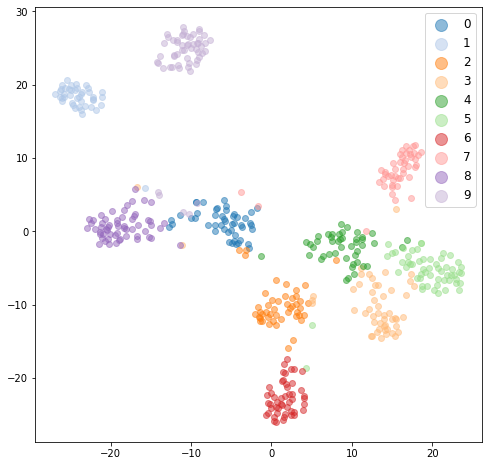

In [29]:
from matplotlib import cm

# Create a two dimensional t-SNE projection of the embeddings
tsne = TSNE(2)
tsne_proj = tsne.fit_transform(test_embeddings)
print(tsne_proj.shape)  #500, 2
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 10
for lab in range(num_categories):
    indices = test_labels==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

(500, 2)


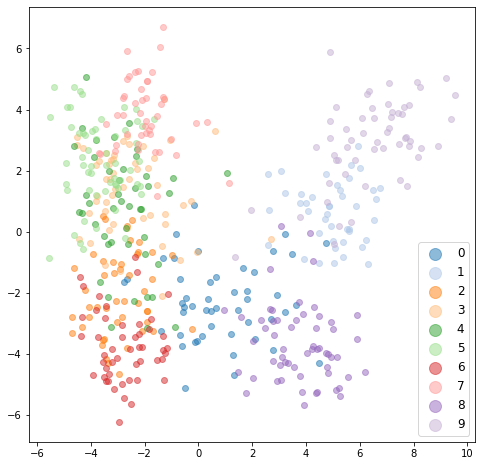

In [37]:
pca = PCA(n_components=2)
pca.fit(test_embeddings)
pca_proj = pca.transform(test_embeddings)
print(pca_proj.shape)  #500, 2
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 10
for lab in range(num_categories):
    indices = test_labels==lab
    ax.scatter(pca_proj[indices,0],pca_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

In [38]:
tsne = TSNE(3, verbose=1)
tsne_proj = tsne.fit_transform(test_embeddings)
cmap = cm.get_cmap('tab20')
num_categories = 10
for lab in range(num_categories):
    indices = test_labels == lab
    ax.scatter(tsne_proj[indices, 0],
               tsne_proj[indices, 1],
               tsne_proj[indices, 2],
               c=np.array(cmap(lab)).reshape(1, 4),
               label=lab,
               alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.053s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 2.883762
[t-SNE] KL divergence after 250 iterations with early exaggeration: 92.343681
[t-SNE] KL divergence after 1000 iterations: 1.266423


/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
